[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds4v/absa-vlsp-2018/blob/main/experiments/Hotel-v1.ipynb)

In [1]:
from google.colab import drive # Move weights to Drive for faster downloading
drive.mount('/content/GoogleDrive', force_remount=True)

Mounted at /content/GoogleDrive


In [2]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q accelerate
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 require

In [3]:
%cd /content/GoogleDrive/MyDrive/ABSA_Mobilephone/experiments
!mkdir predictions
!ls

/content/GoogleDrive/MyDrive/ABSA_Mobilephone/experiments
Mobile_phone_Phobert.ipynb  predictions  weights_phobert


In [4]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append('..')
tf.__version__

'2.15.0'

In [5]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Constants Setup and Load the Data

In [6]:
TRAIN_PATH = r'/content/GoogleDrive/MyDrive/ABSA_Mobilephone/datasets/UIT-ViSD4SA/train.csv'
VAL_PATH = r'/content/GoogleDrive/MyDrive/ABSA_Mobilephone/datasets/UIT-ViSD4SA/dev.csv'
TEST_PATH = r'/content/GoogleDrive/MyDrive/ABSA_Mobilephone/datasets/UIT-ViSD4SA/test.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'mobilephone-v1' # Multitask model on Hotel domain
MAX_LENGTH = 256
BATCH_SIZE = 25
EPOCHS = 20

In [7]:
import sys
sys.path.append('/content/GoogleDrive/MyDrive/ABSA_Mobilephone/processors')

In [8]:
from vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC'],
        num_rows: 7785
    })
    val: Dataset({
        features: ['Review', 'SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC'],
        num_rows: 1112
    })
    test: Dataset({
        features: ['Review', 'SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC'],
        num_rows: 2225
    })
})

# Preprocess and Tokenize the Data

In [9]:
from vietnamese_processor import VietnameseTextPreprocessor

# You should be carefull when using single word replacement for acronyms, because it can cause misinterpretation.
# For example, 'giá': ['price', 'gia'] can replace the word 'gia' in 'gia đình', making it become 'giá đình'.
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processors/VnCoreNLP', extra_teencodes={
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

VnCoreNLP word segmenter is loaded successfully.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

bmd1905/vietnamese-correction-v2 is loaded successfully.


In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .')
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2] 
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
# preprocessed_datasets.save_to_disk('../datasets/mobile')
# display(preprocessed_datasets)
# pd.DataFrame({
#     'raw_datasets': raw_datasets['train']['Review'][1480:1490],
#     'encoded_input_ids': preprocessed_datasets['train']['input_ids'][1480:1490],
#     'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(1480, 1490)]
# })

# Extra Step for ACSA-v1 Solution

In [11]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('../datasets/preprocessed_mobilephone')
preprocessed_datasets = VLSP2018Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets


[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7785
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1112
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2225
    })
})

In [12]:
print('Aspect#Category,Polarity in One-hot form of the first review:')
example_onehot = preprocessed_datasets['train'][0]['FlattenOneHotLabels']
np.array(example_onehot).reshape(-1, 4)

Aspect#Category,Polarity in One-hot form of the first review:


array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

# Prepare for TensorFlow Training

In [13]:
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(ASPECT_CATEGORY_NAMES)

['SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL', 'SER&ACC']


In [14]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True, # You may obtain HIGHER metrics on the test set with longer training time if you set this to False
    # Because after some experiments, I found that even with higher val_loss, it still results in better metric reports on the test set.
    # This maybe because the training set and the test set have more similarities than the validation data.
    # But I think this is not fair, as we already have prior knowledge about the test set and we modified our training based on the performance on this set.
    # In real-world, we should only modify our training based on the performance on the validation data
    verbose = 1
)

# Fine-tuning with TensorFlow

In [16]:
import sys
sys.path.append('/content/GoogleDrive/MyDrive/ABSA_Mobilephone')

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/5


312/312 [==============================] - 567s 1s/step - loss: 0.1893 - val_loss: 0.1420
Epoch 2/5
312/312 [==============================] - 478s 1s/step - loss: 0.1116 - val_loss: 0.1282
Epoch 3/5
312/312 [==============================] - 476s 1s/step - loss: 0.0878 - val_loss: 0.1388
Epoch 4/5
312/312 [==============================] - 476s 1s/step - loss: 0.0801 - val_loss: 0.1349
Epoch 5/5
312/312 [==============================] - 475s 1s/step - loss: 0.0590 - val_loss: 0.1402
Epoch 5: early stopping


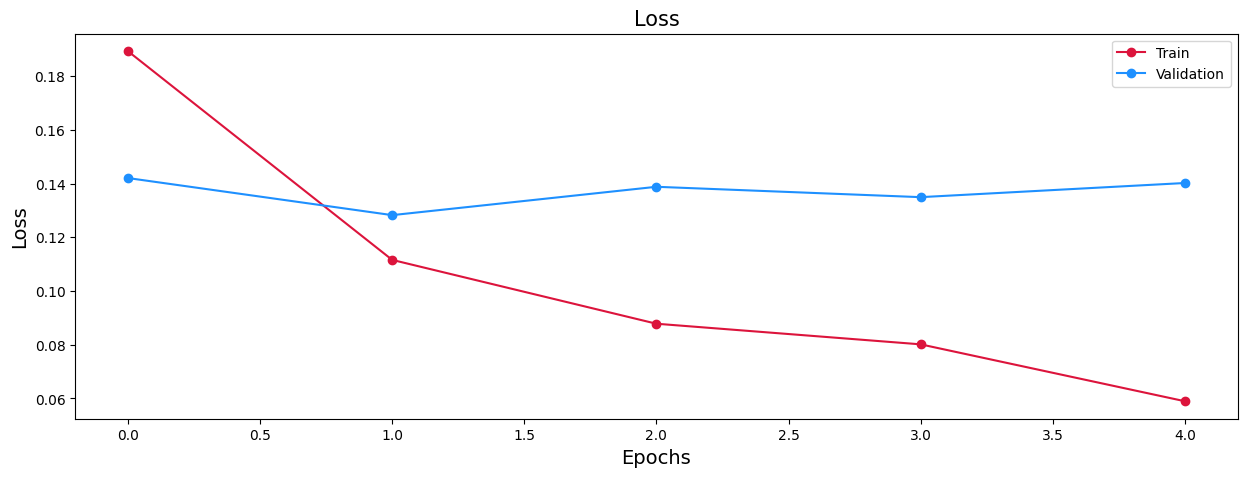

CPU times: user 18min 23s, sys: 4min 53s, total: 23min 16s
Wall time: 43min 34s


In [ ]:
# %%time
# from acsa_model import VLSP2018MultiTask
# from helper import plot_training_history
# model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)

# history = model.fit(
#     train_tf_dataset,
#     validation_data = val_tf_dataset,
#     callbacks = [early_stop_callback],
#     epochs = 10,
#     verbose = 1
# ).history

# model.save_weights(f'./weights_phobert/{MODEL_NAME}/{MODEL_NAME}', save_format='tf')
# plot_training_history(history)

In [ ]:
# # from google.colab import drive # Move weights to Drive for faster downloading
# # drive.mount('/content/GoogleDrive', force_remount=True)
# Zip the weights directory
!zip -r ./weights/{MODEL_NAME}.zip ./weights/{MODEL_NAME}

# Move the zip file to Google Drive
!mv ./weights/{MODEL_NAME}.zip /content/GoogleDrive/My\ Drive

# Predict on the Test Data

In [17]:
from acsa_model import VLSP2018MultiTask
reloaded_model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)
reloaded_model.load_weights(f'./weights_phobert/{MODEL_NAME}/{MODEL_NAME}') # Reload the Model
reloaded_model.evaluate(val_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


45/45 [==============================] - 93s 404ms/step - loss: 0.1282


0.12823893129825592

In [18]:
y_pred = reloaded_model.acsa_predict(test_tf_dataset, BATCH_SIZE) # On test set
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
print('Example:', raw_datasets['test'][0]['Review'])
reloaded_model.print_acsa_pred(y_pred[0])

89/89 [==============================] - 67s 427ms/step - loss: 0.1212
Example: Sp ổn, mỗi tội vân tay lúc nhận lúc không, nhân viên nhiệt tình, pin trâu, cả đêm tụt 1%
=> FEATURES,negative
=> BATTERY,negative
=> GENERAL,positive
=> SER&ACC,positive


In [19]:
from tensorflow.data import Dataset # On a random review by user
random_input = VLSP2018Loader.preprocess_and_tokenize(
    input('Enter your review: '), vn_preprocessor, tokenizer,
    batch_size=1, max_length=MAX_LENGTH
)
tf_inputs = Dataset.from_tensor_slices({x: [[random_input[x][0]]] for x in tokenizer.model_input_names})
random_pred = reloaded_model.acsa_predict(tf_inputs)
reloaded_model.print_acsa_pred(random_pred[0])

Enter your review: Máy sử dụng tốt lắm luôn á nha, nhưng mà mình lại không thích thiết kế của máy vì hơi thô
[INFO] Preprocessing and tokenizing text data...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/1 [==============================] - 8s 8s/step
=> DESIGN,negative
=> GENERAL,positive


# Scikit-learn Evaluation

In [20]:
from helper import argmax_label_matrix
y_test = argmax_label_matrix(preprocessed_datasets['test']['FlattenOneHotLabels'])
y_test

array([[0, 0, 2, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 2],
       [0, 0, 2, ..., 0, 0, 0]])

In [21]:
import sys
sys.path.append('/content/GoogleDrive/MyDrive/ABSA_Mobilephone/evaluators')

In [22]:
from sklearn_evaluator import VLSP2018SklearnEvaluator
sk_eval = VLSP2018SklearnEvaluator(y_test, y_pred, ASPECT_CATEGORY_NAMES)
# sk_eval.report(report_type='Aspect#Category,Polarity').round(3)
# sk_eval.report(report_type='Aspect#Category').round(3)
# sk_eval.report(report_type='Polarity').round(3)
# sk_eval.report(report_type='macro_avg').round(3)
sk_eval.report(report_type='all')

100%|██████████| 13/13 [00:00<00:00, 27235.74it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 BATTERY,positive 
 0.976 0.920 0.947 1018 
 0.933 0.831 0.879 586 
 
 
 
 BATTERY,neutral 
 
 0.353 0.185 0.242 65 
 
 
 
 BATTERY,negative 
 
 0.804 0.886 0.843 367 
 
 
 
 CAMERA,positive 
 0.924 0.949 0.936 588 
 0.900 0.868 0.884 341 
 
 
 
 CAMERA,neutral 
 
 0.536 0.411 0.465 73 
 
 
 
 CAMERA,negative 
 
 0.717 0.902 0.799 174 
 
 
 
 DESIGN,positive 
 0.916 0.843 0.878 376 
 0.891 0.914 0.903 269 
 
 
 
 DESIGN,neutral 
 
 1.000 0.000 0.000 14 
 
 
 
 DESIGN,negative 
 
 0.729 0.548 0.626 93 
 
 
 
 FEATURES,positive 
 0.888 0.849 0.868 730 
 0.674 0.791 0.728 220 
 
 
 
 FEATURES,neutral 
 
 1.000 0.000 0.000 31 
 
 
 
 FEATURES,negative 
 
 0.839 0.770 0.803 479 
 
 
 
 GENERAL,positive 
 0.884 0.900 0.892 1337 
 0.898 0.893 0.895 1053 
 
 
 
 GENERAL,neutral 
 
 0.528 0.691 0.598 55 
 
 
 
 GENERAL,negative 
 
 0.694 0.734 0.713 229 
 
 
 
 PERFORMANCE,positive 
 0.923 0.877 0.899 1169 
 0.839 0.908 0.872 653 
 
 
 
 PERFORMANCE,neutral 
 
 0.455 0.074 0.127 68 
 
 
 
 PERFORMANCE,negative 
 
 0.807 0.708 0.754 448 
 
 
 
 PRICE,positive 
 0.722 0.452 0.556 252 
 0.631 0.631 0.631 122 
 
 
 
 PRICE,neutral 
 
 0.143 0.016 0.029 62 
 
 
 
 PRICE,negative 
 
 0.690 0.294 0.412 68 
 
 
 
 SCREEN,positive 
 0.802 0.765 0.783 260 
 0.846 0.757 0.799 152 
 
 
 
 SCREEN,neutral 
 
 1.000 0.000 0.000 8 
 
 
 
 SCREEN,negative 
 
 0.634 0.710 0.670 100 
 
 
 
 SER&ACC,positive 
 0.932 0.694 0.796 494 
 0.939 0.776 0.850 397 
 
 
 
 SER&ACC,neutral 
 
 1.000 0.000 0.000 3 
 
 
 
 SER&ACC,negative 
 
 0.700 0.298 0.418 94 
 
 
 
 STORAGE,positive 
 0.867 0.382 0.531 34 
 0.786 0.733 0.759 15 
 
 
 
 STORAGE,neutral 
 
 1.000 0.000 0.000 7 
 
 
 
 STORAGE,negative 
 
 1.000 0.083 0.154 12 
 
 
 
 Polarity Report 
 
 
 
 
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 None 
 0.943288 
 0.966233 
 0.954623 
 15992.000 
 
 
 positive 
 0.868414 
 0.852679 
 0.860474 
 3808.000 
 
 
 negative 
 0.772821 
 0.730136 
 0.750872 
 2064.000 
 
 
 neutral 
 0.477778 
 0.222798 
 0.303887 
 386.000 
 
 
 accuracy 
 0.912000 
 0.912000 
 0.912000 
 0.912 
 
 
 macro avg 
 0.765575 
 0.692961 
 0.717464 
 22250.000 
 
 
 weighted avg 
 0.906585 
 0.912000 
 0.908320 
 22250.000 
 
 
 
 Macro Avg Report 
 
 
 
 
 accuracy 
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 Aspect#Category,Polarity 
 0.912 
 0.808 
 0.624 
 0.633 
 22250 
 
 
 Aspect#Category 
 0.934 
 0.889 
 0.782 
 0.822 
 22250 
 
 
 Polarity 
 0.912 
 0.766 
 0.693 
 0.717 
 22250

# VLSP Evaluation

In [ ]:
# from processors.vlsp2018_processor import VLSP2018Parser
# VLSP2018Parser.vlsp_save_as(f'./predictions/{MODEL_NAME}.txt', raw_datasets['test']['Review'], y_pred, ASPECT_CATEGORY_NAMES)
# !java ../evaluators/SAEvaluate.java {TEST_PATH.replace('.csv', '.txt')} ./predictions/{MODEL_NAME}.txt

# Download & open zookeeper and server

In [23]:
!curl -sSOL https://downloads.apache.org/kafka/3.7.0/kafka_2.13-3.7.0.tgz

In [24]:
!tar -xzf kafka_2.13-3.7.0.tgz

In [25]:
!./kafka_2.13-3.7.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.7.0/config/zookeeper.properties
!./kafka_2.13-3.7.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.7.0/config/server.properties

#Pyspark


In [ ]:
# !pip install pyspark==3.2.0

In [ ]:
# from pyspark.sql import SparkSession

# scala_version = '2.13'
# spark_version = '3.2.0'
# packages = [
#     f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
#     'org.apache.kafka:kafka-clients:3.7.0'
# ]

# spark = SparkSession.builder \
#     .master("local") \
#     .appName("kafka-example") \
#     .config("spark.jars.packages", ",".join(packages)) \
#     .getOrCreate()

# spark

#Kafka

In [26]:
!pip install kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 5.8 MB/s eta 0:00:00


In [31]:
from kafka import KafkaProducer
from json import dumps
from pyspark.sql import SparkSession
import time

# Định nghĩa Kafka producer
topic_name = 'ABSA'
kafka_server = 'localhost:9092'
producer = KafkaProducer(
    bootstrap_servers=kafka_server,
    value_serializer=lambda x: dumps(x).encode('utf-8')
)

# Đọc dữ liệu từ CSV
test_df = spark.read.csv("/content/lazada_comment.csv", header=True, inferSchema=True)
test_df = test_df.na.drop()

# Chọn cột mong muốn
selected_columns = ["comment"]
test_df = test_df.select(*selected_columns).limit(100)

# Gửi dữ liệu từ DataFrame đến Kafka
for row in test_df.rdd.collect():
    message = row.asDict()
    producer.send(topic_name, key=None, value=message)
    print("Sent message:", message)
    time.sleep(1)  # Điều chỉnh khoảng thời gian giữa các tin nhắn nếu cần


Sent message: {'comment': 'Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎'}
Sent message: {'comment': 'Nhỏ vào mắt thấy hơi xót, hàng này tôi nghi hàng giả ạHỗ trợ mở lại tài khoản để tiếp tục mua sắm ạ'}
Sent message: {'comment': 'hàng chính hãng .máy đẹp mượt mà. nhưng đặt giao hoả tốc mà còn chậm hơn giao bình thường. đánh giá 1 sao cho shiper Ahamove'}
Sent message: {'comment': 'Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎'}
Sent message: {'comment': 'Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎'}
Sent message: {'comment': 'Sử dụng chất liệu cao cấp, Dung lượng lưu trữ ấn tượng, Chất lượng camera ấn tượng,  '}
Sent message: {'comment': 'mua sản phẩm đắt tiền online cũng sợ lắm á,mà nhận hàng thấy hài lòng này '}
Sent message: {'comment': 'Giao hàng nhanh, sẽ ủng hộ tiếp, mua đồ được áp xu lzd nên rẻ hơn '}
Sent message: {'comme

#Test

In [ ]:
!./kafka_2.13-3.7.0/bin/kafka-console-consumer.sh --topic Number1 --from-beginning --bootstrap-server 127.0.0.1:9092

In [32]:
from kafka import KafkaProducer
from json import dumps
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, udf
from pyspark.sql.types import StructType, StructField, StringType, ArrayType

# Initialize SparkSession
spark = SparkSession.builder.appName("KafkaSparkApp").getOrCreate()

# Kafka Configuration
kafka_server = 'localhost:9092'
topic_name = 'ABSA'

# Define schema for Kafka data
schema = StructType([StructField("comment", StringType(), True)])

# Function to get ACSA prediction as a string
def get_acsa_prediction(prediction):
    sentiment_labels = ['positive', 'negative', 'neutral']
    prediction_str = []
    for i, val in enumerate(prediction):
        if val == 1:
            prediction_str.append(f"{ASPECT_CATEGORY_NAMES[i]}#{sentiment_labels[0]}")
        elif val == 2:
            prediction_str.append(f"{ASPECT_CATEGORY_NAMES[i]}#{sentiment_labels[1]}")
        elif val == 3:
            prediction_str.append(f"{ASPECT_CATEGORY_NAMES[i]}#{sentiment_labels[2]}")
    return prediction_str

# Function to predict sentiment
def predict_sentiment(comment):
    print(f"Review: {comment}")  # Debugging: Print the review

    # Preprocess and tokenize the review
    processed_input = VLSP2018Loader.preprocess_and_tokenize(
        comment, vn_preprocessor, tokenizer,
        batch_size=1, max_length=MAX_LENGTH
    )

    # Create TensorFlow inputs
    tf_inputs = Dataset.from_tensor_slices({x: [[processed_input[x][0]]] for x in tokenizer.model_input_names})

    # Predict sentiment
    prediction = reloaded_model.acsa_predict(tf_inputs)
    prediction_result = reloaded_model.print_acsa_pred(prediction[0])
    prediction_str = get_acsa_prediction(prediction[0])

    return prediction_str

# Register UDF
predict_sentiment_udf = udf(predict_sentiment, ArrayType(StringType()))

# Read data from Kafka
kafkaDf = spark.read.format("kafka") \
    .option("kafka.bootstrap.servers", kafka_server) \
    .option("subscribe", topic_name) \
    .option("startingOffsets", "earliest") \
    .load()

# Convert value column from binary to string
kafkaDf = kafkaDf.withColumn("value", col("value").cast("string"))

# Parse JSON and extract "comment" field
parsed_df = kafkaDf.select(from_json(col("value"), schema).alias("data")).select("data.comment")

# Apply UDF to predict sentiment
result_df = parsed_df.withColumn("prediction", predict_sentiment_udf(col("comment")))

Review: Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎
[INFO] Preprocessing and tokenizing text data...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/1 [==============================] - 0s 27ms/step
=> GENERAL,positive
=> SER&ACC,positive
Review: Nhỏ vào mắt thấy hơi xót, hàng này tôi nghi hàng giả ạHỗ trợ mở lại tài khoản để tiếp tục mua sắm ạ
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 17ms/step
Review: hàng chính hãng .máy đẹp mượt mà. nhưng đặt giao hoả tốc mà còn chậm hơn giao bình thường. đánh giá 1 sao cho shiper Ahamove
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 18ms/step
=> PERFORMANCE,negative
=> DESIGN,positive
Review: Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 22ms/step
=> GENERAL,positive
=> SER&ACC,positive
Review: Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎
[INFO] Preprocessing and tokenizing text data...
1/1 [===============

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=> PRICE,positive
=> SER&ACC,positive
Review: Sử dụng chất liệu cao cấp, Thiết kế sang trọng và hiện đại,  
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 17ms/step
=> DESIGN,positive
Review: Thiết kế sang trọng và hiện đại, Màu đẹp đổi dưới điều kiện ánh sáng khác nhau 
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 18ms/step
=> DESIGN,positive
Review: giao hàng nhanh chóng, đóng gói caan thận chắc chắn, lhas là ok 
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 17ms/step
=> DESIGN,positive
=> GENERAL,positive
=> SER&ACC,positive
Review: Nhận hàng nhưng liên hệ với shop k ai trả lời. K có kèm giấy hoá đơn của shop nên k biết chế độ bảo hành ntn. 
[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 0s 21ms/step
Review: Giao hàng hơi lâu, đặt hàng 12/12/2023 mà 15/12/2023 mới giao 
[INFO] Preprocessing and tokenizing text

In [33]:
# Show result DataFrame
result_df.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------+
|comment                                                                                                                     |prediction                                           |
+----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------+
|Chất lượng sản phẩm tuyệt vời! Đóng gói cẩn thận! Vận chuyển hàng nhanh! Sẽ ủng hộ shop lâu dài.😎                          |[GENERAL#positive, SER&ACC#positive]                 |
|Nhỏ vào mắt thấy hơi xót, hàng này tôi nghi hàng giả ạHỗ trợ mở lại tài khoản để tiếp tục mua sắm ạ                         |[]                                                   |
|hàng chính hãng .máy đẹp mượt mà. nhưng đặt giao hoả tốc mà còn chậm hơn giao bình thường. đánh

#Scale

In [27]:
!apt-get remove scala-library scala

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'scala' is not installed, so not removed
Package 'scala-library' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [28]:
!wget https://downloads.lightbend.com/scala/2.12.15/scala-2.12.15.deb
!dpkg -i scala-2.12.15.deb
!apt-get update
!apt-get install scala

--2024-07-23 10:01:42--  https://downloads.lightbend.com/scala/2.12.15/scala-2.12.15.deb
Resolving downloads.lightbend.com (downloads.lightbend.com)... 52.84.229.28, 52.84.229.6, 52.84.229.31, ...
Connecting to downloads.lightbend.com (downloads.lightbend.com)|52.84.229.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153627102 (147M) [application/octet-stream]
Saving to: ‘scala-2.12.15.deb’

scala-2.12.15.deb   100%[===================>] 146.51M  47.8MB/s    in 3.1s    

2024-07-23 10:01:45 (47.8 MB/s) - ‘scala-2.12.15.deb’ saved [153627102/153627102]

Selecting previously unselected package scala.
(Reading database ... 123589 files and directories currently installed.)
Preparing to unpack scala-2.12.15.deb ...
Unpacking scala (2.12.15-400) ...
Setting up scala (2.12.15-400) ...
Creating system group: scala
Creating system user: scala in scala with scala daemon-user and shell /bin/false
Processing triggers for man-db (2.10.2-1) ...
Get:1 https://cloud.r-pro

In [29]:
!pip install pyspark==3.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.1/209.1 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 31.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435950 sha256=8efbca27973fd3d60e4061338545c305cfc31216242d1a926e9876e4e7d3a3ea
  Stored in directory: /root/.cache/pip/wheels/40/50/14/79047c3c171b701e591d287b78a201214d9c8e0b93fef64458
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [30]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("KafkaConsumer") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.3") \
    .getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
